Prática 6 - Ciências de Dados

**Matheus Marzola Gomes 9779270**

**Victor Henrique De Souza Rodrigues 9791027**

Datasets: Breast Cancer

In [8]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import datasets

cancer = datasets.load_breast_cancer()
cols = cancer['feature_names'].tolist()
cols.append('target')
cancer = pd.DataFrame(data=np.c_[cancer['data'], cancer['target']],
                       columns = cols
                     )

cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [9]:
cancer = cancer[['mean texture', 'mean perimeter', 'mean area', 'mean concavity', 'mean symmetry', 'mean radius', 'mean concave points', 'target']]

# 1

- De acordo com as últimas práticas, os atributos escolhidos tem alta relação com o target e imlicam no câncer maligno ou benigno. Adicionamos outros que são de grande importância e influenciam no resultado final de classificação.

- Escolhemos a medida TFN que calcula a taxa de falsos negativos e a acurácia. A escolha da TFN é devido ao domínio do problema que é relacionado à gravidade de um tumor e é preferível ter falsos positivos do que falsos negativos, achamos que a TFN mostra o que mais nos preocupamos. A acurácia mostra de maneira geral e clara a taxa dos acertos e erros.

In [10]:
cancer.corr()

,mean texture,mean perimeter,mean area,mean concavity,mean symmetry,mean radius,mean concave points,target
mean texture,1.000000,0.329533,0.321086,0.302418,0.071401,0.323782,0.293464,-0.415185
mean perimeter,0.329533,1.000000,0.986507,0.716136,0.183027,0.997855,0.850977,-0.742636
mean area,0.321086,0.986507,1.000000,0.685983,0.151293,0.987357,0.823269,-0.708984
mean concavity,0.302418,0.716136,0.685983,1.000000,0.500667,0.676764,0.921391,-0.696360
mean symmetry,0.071401,0.183027,0.151293,0.500667,1.000000,0.147741,0.462497,-0.330499
mean radius,0.323782,0.997855,0.987357,0.676764,0.147741,1.000000,0.822529,-0.730029
mean concave points,0.293464,0.850977,0.823269,0.921391,0.462497,0.822529,1.000000,-0.776614
target,-0.415185,-0.742636,-0.708984,-0.696360,-0.330499,-0.730029,-0.776614,1.000000


In [11]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

def classificacao(data, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')
    
    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=folds, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    preds = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    tests = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # valores predito pelo classificador
            y_pred = clf.predict(x_test)
            # rótulos verdadeiros convertidos para array
            y_test = np.array(y_test)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )
            preds[c_name].append(y_pred)
            tests[c_name].append(y_test)
    
    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs, 'preds':preds, 'tests':tests}



In [12]:
from sklearn.metrics import accuracy_score

# FUNÇÃO PARA IMPLEMENTAR O FALSO NEGATIVO

def pen_falso_negativo(y_true, y_pred):
    import numpy as np
    # positivo == 1
    # negativo == 0
    count = 0
#    print(y_true.unique())
#    print()
#    print(y_pred.unique())
    for i,j in enumerate(y_pred):
        # falso positivo, retornou j==1 mas era pra ser 0
        
        # LEIA OBSERVAÇÃO NO PROXIMO BLOCO DO NOTEBOOK
        if y_true[i] == 0 and j == 1:
            count += 2
        elif y_true[i] == 1 and j == 0:
            count += 1
    return count/len(y_true)



# 2)

**OBS:** nesse caso, escolhemos falso negativo que significa classificarmos como benigno(1) quando na verdade é maligno(0). Nessa função, caso o nosso predição j seja igual a 1(benigno) e na verdade é 0(maligno) então deu um falso negativo e o count soma 2. Caso j seja 0 e na verdade era pra ser 1, então deu um falso positivo.

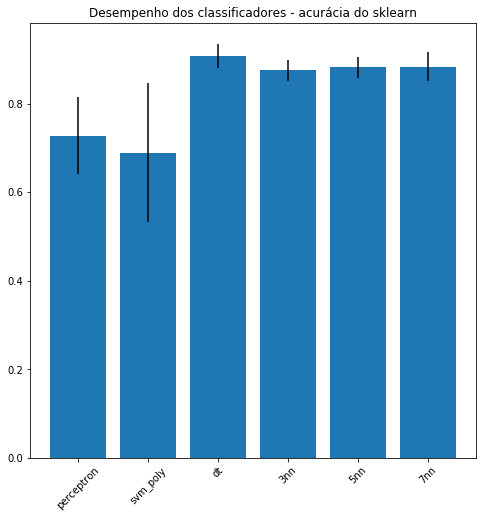

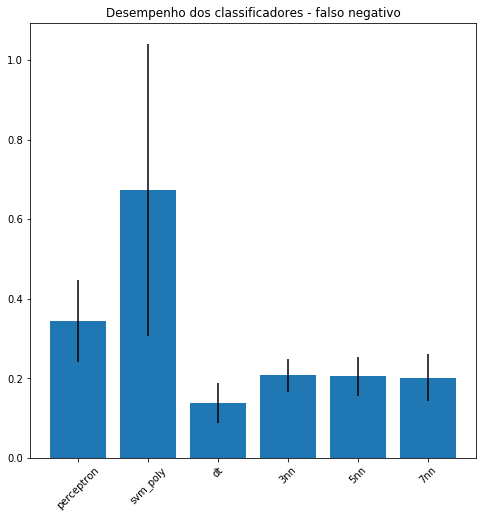

In [13]:
target = len(cancer.columns) -1
columns = list(range(target))


clf_acc = classificacao(cancer, columns, target, accuracy_score, 'acurácia do sklearn')
clf_tfn = classificacao(cancer, columns, target, pen_falso_negativo, 'falso negativo')

Nas duas medidas, a árvore de decisão teve um melhor desempenho final. Acreditamos que isso ocorre pois todos os atributos escolhidos tem uma significante correlação com o target. Os intervalos em que o câncer é maligno e benigno estão bem definidos e a simplicidade desse modelo, em grande parte das vezes, indica uma predição melhor.

# 3)

In [14]:
# SUBAMOSTRAGEM

sub_cancer = cancer.sample(n=200)
print ("tamanho da subamostragem:", sub_cancer.shape[0])

# SUPERAMOSTRAGEM
sobre_cancer = cancer.append(cancer.sample(n=cancer.shape[0]))
sobre_cancer = sobre_cancer.append(sobre_cancer.sample(n=sobre_cancer.shape[0]))
print ("Tamanho da superamostragem", sobre_cancer.shape[0])

tamanho da subamostragem: 200
Tamanho da superamostragem 2276


## Leave one out

### Com superamostragem

In [ ]:
clf_loo_acc_sobre = classificacao(sobre_cancer, columns, target, pen_falso_negativo, 'falso negativo no leave one out com superamostragem', 
                        folds=sobre_cancer.shape[0])

### Com subamostragem

In [ ]:
clf_loo_acc_sub = classificacao(sub_cancer, columns, target, pen_falso_negativo, 'falso negativo no leave one out com subamostragem', 
                        folds=sub_cancer.shape[0])

## 10 fold cross-validation

### Com superamostragem

In [ ]:
clf_10fold_acc_sobre = classificacao(sobre_cancer, columns, target, pen_falso_negativo, 'falso negativo no 10 fold cross validation com superamostragem', 
                        folds=10)

### Com subamostragem

In [ ]:
clf_10fold_acc_sub = classificacao(sub_cancer, columns, target, pen_falso_negativo, 'falso negativo no 10 fold cross validation com superamostragem', 
                        folds=10)

## Bootstrap

In [ ]:


# COPIEI CODIGO DA FUNCAO classificacao MAS MODIFIQUEI PARA TRATAR AS AMOSTRAS DE BOOTSTRAP

from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Perceptron

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')
def classificacao_bootstrap(bootstrap_dts, columns, target, score=accuracy_score, score_name='acurácia', 
                  folds=5, plot=True):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    score:      Função. A função que calcula a medida de desempenho desejada. Deve ser uma 
                função que compara dois vetores, o primeiro vetor são os valores preditos
                pelo classificador, o segundo os rótulos reais
                Vide exemplo das funções em 
                http://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics
                como por exemplo, sklearn.metrics.accuracy_score
                http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    score_name: String. Uma string com o nome da medida de desempenho
    folds:      Inteiro. Número de folds na validação cruzada
    plot:       Booleano. True para plotar os gráficos False para não plotar
    ---------------------------------------------------------------
    Realiza a classificação em 6 modelos (perceptron, 
    SVM com kernel polinomial de grau 3, Árvore de decisão, 3NN, 5NN, e 7NN)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    import numpy as np
    # inicializa os modelos com os parâmetros solicitados
    prcp = Perceptron()
    svm_n = SVC(C=10*len(bootstrap_dts[0]), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(bootstrap_dts[0])*0.1))
    _3nn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')
    _5nn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
    _7nn = KNeighborsClassifier(n_neighbors=7, weights='uniform', algorithm='auto')

    clfs = [prcp, svm_n, dt, _3nn, _5nn, _7nn]
    clfs_names = ['perceptron', 'svm_poly', 'dt', '3nn', '5nn', '7nn']


    # itera para cada classificador fazendo treino e teste
    results = {'perceptron':[], 'svm_poly':[], 'dt':[], '3nn':[], '5nn':[], '7nn':[]}
    for c, c_name in zip(clfs, clfs_names):
        for dt_boot in bootstrap_dts:

            # separa 80% para treino e 20% para teste
            test = dt_boot.sample(n=int(N_samples*0.2), replace=False)
            train = dt_boot.iloc[-test.index]

            # faz o treino do modelo
            clf = c.fit(X=train.iloc[:, columns], y=train.iloc[:, target])

            # valores predito pelo classificador
            y_pred = clf.predict(test.iloc[:, columns])
            # rótulos verdadeiros convertidos para array
            y_test = np.array(test.iloc[:, target])

            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( score(y_test, y_pred) )

    if not plot:
        return {'results': results, 'clfs':clfs}
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - %s'%(score_name)
    plt.title(title)
    plt.show()
    
    return {'results': results, 'clfs':clfs}


### Com superamostragem

In [ ]:
# criando amostras de bootstrap
dt = sobre_cancer.copy()
N_btp_samples = 1000
N_samples = dt.shape[0]
bootstrap_dts = [dt.sample(n=N_samples, replace=True) for i in range(N_btp_samples)]

# cada amostra de bootstrap tem o mesmo número de exemplos do dataset original

# exemplo de como usar diferentes funções que calcula medida de desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

clf_boot_acc = classificacao_bootstrap(bootstrap_dts, columns, target, 
                                  pen_falso_negativo, 'falso negativo do sklearn com Bootstrap')

### Com subamostragem

In [ ]:
# criando amostras de bootstrap
dt = sub_cancer.copy()
N_btp_samples = 1000
N_samples = dt.shape[0]
bootstrap_dts = [dt.sample(n=N_samples, replace=True) for i in range(N_btp_samples)]

# cada amostra de bootstrap tem o mesmo número de exemplos do dataset original

# exemplo de como usar diferentes funções que calcula medida de desempenho
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

clf_boot_acc = classificacao_bootstrap(bootstrap_dts, columns, target, 
                                  pen_falso_negativo, 'falso negativo do sklearn com Bootstrap')

# 4)

In [ ]:
# PRINTANDO OS VETORES DE ITERAÇÃO DE UM CLASSIFICADOR 

clf_10fold_acc_sub['preds']['perceptron']
#confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)

- **OBS1: Para gerar a matriz de confusão, precisamos de um vetor y de predição do algoritmo rodado e um vetor y do valor real para teste. Observamos que, para cada um dos classificadores, no código disponibilizado, ele vai ter os vetores y para cada um dos folds. Portanto, para gerar a matriz de confusão utilizando o cross fold validation seria necessário gerar uma matriz de confusão para cada um dos folds. Responderemos a questão sem rodar porque daria muitas matrizes.**

- O melhor classificador vai depender do seu objetivo final de acordo com o seu problema e de acordo com a precisão do algoritmo em cada uma dessas medidas de avaliação. Por exemplo, eu escolheria um classificador que vai bem na penalização do falso negativo pois para identificação de câncer isso é mais grave, mesmo se eu tiver um outro classificador que tenha mais precisão em outra medida de avaliação. Concluímos que é necessário fazer uma avaliação do seu objetivo e dos resultados finais.

- **OBS2: A Classificacao usando sub e sobre amostragem ficou rodando durante seis horas e ainda assim nao foi finalizada, dessa forma, nao conseguimos saber como que o dataset responderia nesses testes. 